# Fake Face Detection
### EE 596 Intro to Deep Learning Applications and Theory Final Project 
#### Girish Narayanswamy

### Project Description

This project takes a dataset comprised of the following kaggle datasets:

1. https://www.kaggle.com/xhlulu/140k-real-and-fake-faces/code
2. https://www.kaggle.com/ciplab/real-and-fake-face-detection/code

These datasets hold both real and fake (GAN generated and Photoshopped) pictures of human faces. This project trains a model (VGG19) to classify face-images as real or fake. 

The Project further explores methods of model understanding such as saliency maps. 

### Imports

In [ ]:
# IMPORTS

# Learning Packages
import torch # pytorch
from torch import nn # pytorch neural networks
import torchvision
import torchvision.transforms as T # image transforms
import torchvision.models as models # pre-built models
import torch.nn.functional as F

import cv2 # opencv for image plotting

# Math
import numpy as np
import random

# Plotting
import matplotlib.pyplot as plt # plotting 

# File Things
import os # file system access
import zipfile # unzipping dataset
from google.colab import drive # google drive 

#drive.mount('/content/drive')

In [ ]:
#Import dataset from zip in google drive 

data_path = '/content/drive/MyDrive/classes/EE596_intro_to_DL/final_project/code/' # directory path
file_name = '140k_faces_kaggle_dataset.zip' # file name 

zip_ref = zipfile.ZipFile(data_path + file_name, 'r') # Open zip file in read mode
zip_ref.extractall('/tmp') # Extract files into /tmp folder
zip_ref.close() # cloze zip file 

### Train / Validation / Test Dataset Split

In [ ]:
# Dataset paths
train_path = '/tmp/real_vs_fake/real-vs-fake/train'
val_path = '/tmp/real_vs_fake/real-vs-fake/valid'
test_path = '/tmp/real_vs_fake/real-vs-fake/test'


# Define Img Transform 
imgTransform = T.Compose([T.ToTensor(), 
                          T.Resize(size=(224,224)), 
                          T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# Define datasets 
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=imgTransform)
val_data = torchvision.datasets.ImageFolder(root=val_path, transform=imgTransform)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=imgTransform)

# Batch sizes
train_batch_size = 64 
val_batch_size = 100
test_batch_size  = 100 

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=val_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=test_batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


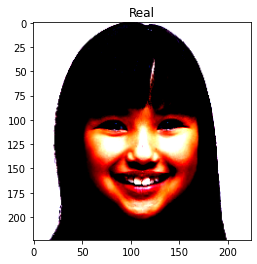

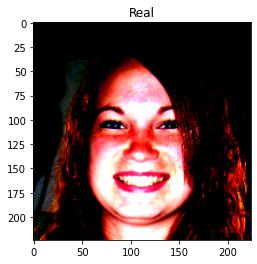

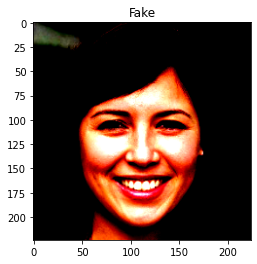

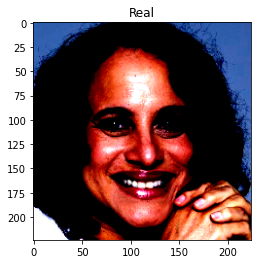

In [ ]:
# Sample Images

sample_data, sample_labels = iter(train_loader).next()

for i in range(4):
  img = sample_data[i].numpy()
  label = sample_labels[i].item()

  img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
  
  if label == 1:
    plt_label = 'Real'
  else:
    plt_label = 'Fake'

  plt.figure();
  plt.imshow(img);
  plt.title(plt_label);


### Hyper Parameters and Model Definition

In [ ]:
# Attach GPU

print(torch.cuda.device_count()) # number of GPUS attached 
print(torch.cuda.get_device_name(0)) # information about attached GPU

cuda0 = torch.device('cuda:0')

1
Tesla P100-PCIE-16GB


#### VGG19

In [ ]:
# Import and Edit VGG19 Network
model = models.vgg19(pretrained=True) # vgg19 model (pre-trained)
for param in model.parameters(): # freeze the layers
   param.requires_grad = False

# Edit final Layer
number_features = model.classifier[6].in_features # Get number of inputs into final layer
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 2)]) # Add new layer w/ 2 outputs 
model.classifier = torch.nn.Sequential(*features) # Replace existing classifier
model = model.to(cuda0) # move model to GPU

print('Model Architecture')
print(model)

# Optimizer, Loss, Epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # adam optimizer 
loss_fn = nn.CrossEntropyLoss() # cross entropy loss function
epoch_count = 3 # number of epochs

# Plotting lists and variables
val_accuracy_list = [] # track validation accuracy 
batch_count_list = [] # count number of batches 
batch_count = 0 # batch count variable 


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Model Architecture
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3),

#### DENSENET 121

In [ ]:
# Import and Edit DENSENET 121 Network
model = models.densenet121(pretrained=False)
for param in model.parameters(): # freeze the layers
   #param.requires_grad = False
   param.requires_grad = True

# Edit final Layer
number_features = model.classifier.in_features # Get number of inputs into final layer

# Use with Cross Entropy Loss
features = list(model.classifier.children())[:-1] # Remove last layer

#1
#features.extend([.nn.Linear(number_features, 2)]) # Add new layer w/ 2 outputs 

#2
features.extend([nn.Linear(number_features, int(number_features/2)), nn.ReLU(), nn.Dropout(), nn.Linear(int(number_features/2), 2)])

#3
#features.extend([nn.Linear(number_features, int(number_features/2)), nn.ReLU(), nn.BatchNorm1d(int(number_features/2)), nn.Dropout(), nn.Linear(int(number_features/2), 2)])
model.classifier = nn.Sequential(*features) # Replace existing classifier

# Use with BCE Loss
#features = list(model.classifier.children())[:-1] # Remove last layer

#4
#features.extend([nn.Linear(number_features, int(number_features/2)), nn.ReLU(), nn.BatchNorm1d(int(number_features/2)), nn.Dropout(), nn.Linear(int(number_features/2), 1), nn.Sigmoid()])
#model.classifier = nn.Sequential(*features) # Replace existing classifier

# move model to GPU
model = model.to(cuda0) # move model to GPU

print('Model Architecture')
print(model)

Model Architecture
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

#### Hyperparameters

In [ ]:
# Optimizer, Loss, Epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # adam optimizer 
loss_fn = nn.CrossEntropyLoss() # cross entropy loss function
#loss_fn = nn.BCELoss()
epoch_count = 10 # number of epochs

# Plotting lists and variables
train_loss_list = []
val_accuracy_list = [] # track validation accuracy 
val_loss_list = []
batch_count_list = [] # count number of batches 
batch_count = 0 # batch count variable 

### Training

epoch num: 0
batch count: 1563 | accuracy: 0.80355
epoch num: 1
batch count: 3126 | accuracy: 0.90555
epoch num: 2
batch count: 4689 | accuracy: 0.95585
epoch num: 3
batch count: 6252 | accuracy: 0.96245
epoch num: 4
batch count: 7815 | accuracy: 0.9651
epoch num: 5
batch count: 9378 | accuracy: 0.97265
epoch num: 6
batch count: 10941 | accuracy: 0.9693
epoch num: 7
batch count: 12504 | accuracy: 0.9694
epoch num: 8
batch count: 14067 | accuracy: 0.97765
epoch num: 9
batch count: 15630 | accuracy: 0.9804


Text(0, 0.5, 'Loss')

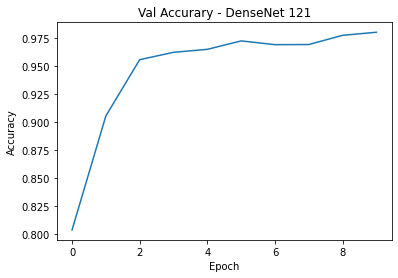

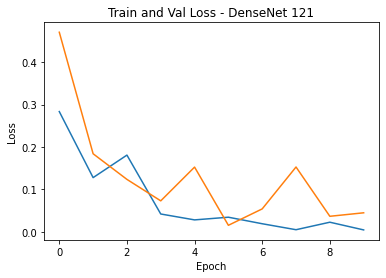

In [ ]:
PER_EPOCH_VAL = True
PER_BATCH_VAL = False
SAVE_MODEL = True
MODEL_PATH = '/content/drive/MyDrive/classes/EE596_intro_to_DL/final_project/code/densenet121model5.pth' # path to save model

best_val_acc = 0 # best validation accuracy - used to save best model

for epoch in range(epoch_count): # iterate through epochs

    print('epoch num:', epoch) # print the epoch
    
    train_loss = 0 # Training loss on model
    for train_sample in train_loader:
        x = train_sample[0] # input 
        y = train_sample[1] # labels
        x, y = x.to(cuda0), y.to(cuda0) # send inputs and labels to GPU
    
        model.train()
        y_pred = model(x) # forward pass x through model
        #y_pred = torch.squeeze(y_pred, dim=1) # for BCE

        #loss = loss_fn(y_pred.float(), y.float()) # calculate loss - BCE
        loss = loss_fn(y_pred, y) # calculate loss - X - Entropy
        train_loss = loss
        
        # Zero gradients
        optimizer.zero_grad() # zero gradients 
        loss.backward() # back prop
        optimizer.step() # adjust loss

        # Test on Validation Set Every ____ Batches
        if PER_BATCH_VAL:
            # Calculate loss on validation set
            if (batch_count % 50) == 0: # every 30 batches of training 
                val_loss = 0
                total_val_count = 0 # total number of test inputs
                total_val_correct = 0 # total correct classifications
                
                for val_sample in val_loader: # iterate through batches in test_loader
                    x_val = val_sample[0] 
                    y_val = val_sample[1]
                    x_val, y_val = x_val.to(cuda0), y_val.to(cuda0) # send inputs and labels to GPU

                    model.eval()
                    with torch.no_grad(): # no weight adjustment 
                        y_val_pred_probs = model(x_val) # calculate labels for test input batch
                        val_loss = loss_fn(y_val_pred_probs, y_val) # calculate loss  

                    _, y_val_pred = torch.max(y_val_pred_probs, 1)
                    val_correct = torch.sum(y_val_pred == y_val)
                    total_val_correct += val_correct.item()
                    total_val_count += y_val.size()[0]
                
                val_accuracy = total_val_correct/total_val_count

                # Plotting and Printing
                val_accuracy_list.append(val_accuracy)
                val_loss_list.append(val_loss) 
                batch_count_list.append(batch_count)
                print('batch count:', batch_count, '| accuracy:', val_accuracy)
            
        batch_count += 1 # increment batch count
    train_loss_list.append(train_loss) # Append most recent loss to training loss list at end of epoch
    
    # Test on Validation Set Every Epoch
    if PER_EPOCH_VAL:
        val_loss = 0
        total_val_count = 0 # total number of test inputs
        total_val_correct = 0 # total correct classifications
        
        for val_sample in val_loader: # iterate through batches in test_loader
            x_val = val_sample[0] 
            y_val = val_sample[1]
            x_val, y_val = x_val.to(cuda0), y_val.to(cuda0) # send inputs and labels to GPU

            model.eval()
            with torch.no_grad(): # no weight adjustment 
                y_val_pred_probs = model(x_val) # calculate labels for test input batch
                val_loss = loss_fn(y_val_pred_probs, y_val) # calculate loss - X Entropy

                #y_val_pred_probs = torch.squeeze(y_val_pred_probs, dim=1) # for BCE
                #val_loss = loss_fn(y_val_pred_probs.float(), y_val.float()) # calculate loss - BCE


            _, y_val_pred = torch.max(y_val_pred_probs, 1) # X Entropy Case
            #y_val_pred = torch.round(y_val_pred_probs) # BCE Case
            val_correct = torch.sum(y_val_pred == y_val)
            total_val_correct += val_correct.item()
            total_val_count += y_val.size()[0]

        val_accuracy = total_val_correct/total_val_count

        # Plotting and Printing
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss)
        batch_count_list.append(batch_count)
        print('batch count:', batch_count, '| accuracy:', val_accuracy)

        # Saving Model 
        if val_accuracy > best_val_acc and SAVE_MODEL: # If best validation accuracy yet - save model
            model_path = MODEL_PATH # model path
            torch.save(model.state_dict(), model_path)


plt.figure()
plt.plot(val_accuracy_list)
plt.title('Val Accurary - DenseNet 121')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Train and Val Loss - DenseNet 121')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

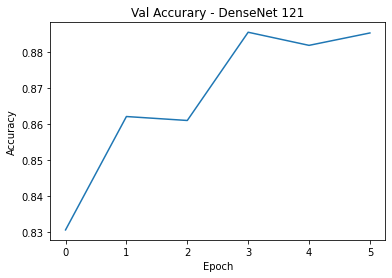

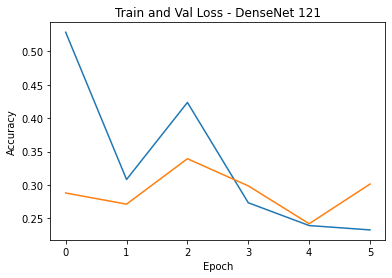

In [ ]:
plt.figure()
plt.plot(val_accuracy_list)
plt.title('Val Accurary - DenseNet 121')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Train and Val Loss - DenseNet 121')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
model_path = '/content/drive/MyDrive/classes/EE596_intro_to_DL/final_project/code/densenet121model1.pth'
torch.save(model.state_dict(), model_path)

### Testing

In [ ]:
#Calculate loss on test set - After all training done
total_test_count = 0 # total number of test inputs
total_test_correct = 0 # total correct classifications

for test_sample in test_loader: # iterate through batches in test_loader
    x_test = test_sample[0]
    y_test = test_sample[1]
    x_test, y_test = x_test.to(cuda0), y_test.to(cuda0) # send inputs and labels to GPU
    
    with torch.no_grad(): # no weight adjustment 
        pred_probs = model(x_test) # calculate labels for test input batch
    
    _, y_test_pred = torch.max(pred_probs, 1)
    test_correct = torch.sum(y_test_pred == y_test)
    total_test_correct += test_correct.item()
    total_test_count += y_test.size()[0]

    
print('Test Accuracy:', total_test_correct/total_test_count)


Test Accuracy: 0.906


### Model Understanding
